<a href="https://colab.research.google.com/github/OnurKerimoglu/Colab_Notebooks/blob/master/DSR_2_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np

In [7]:
datasets,info = tfds.load(
    "imdb_reviews/plain_text",
    split = ["train","test[:50%]","test[50%:]"],
    as_supervised = True,
    with_info = True
)
dataset_train_original = datasets[0]
dataset_validate_original = datasets[1]
dataset_test_original = datasets[2]
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset.
    This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        '

In [ ]:
for x,y in dataset_train_original.shuffle(1000).take(1):
  print(x.numpy().decode("utf-8"))
  print(y.numpy())

There is a bit of trivia which should be pointed out about a scene early in the movie where Homer watches the attempt of December 6, 1957 (at least that was the video used on the TV he was watching) which showed the Vangard launch attempt, which failed.<br /><br />He is next shown reading or dictating a letter to Dr. Von Braun offering condolences about the failure.<br /><br />Von Braun was at Marshall space flight center in Huntsville working for the Army. The Vanguard project was by the early Nasa team which was at what soon became Goddard Space flight center.<br /><br />The army rushed the Jupiter-C, which was essentially a US made V2 technology, but worked to launch a satellite in response to Russia's success with Sputnik.<br /><br />This error may have actually been made by Homer, because of the notoriety of Von Braun, but his team didn't have their attempt fail. In fact the underlying Redstone was flying from 52 and was the first US man rated booster, used for Shepard's sub orbit

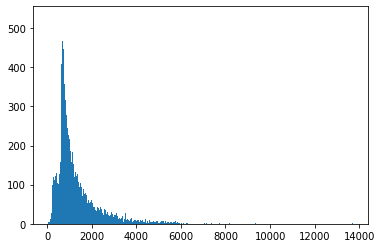

In [ ]:
#Let's do a histogram of number of characters within the entire train sample
lengths = []
for x,_ in dataset_train_original:
  x = x.numpy().decode("utf-8")
  lengths += [len(x)]
plt.hist(lengths,bins=1000)
plt.show()
plt.close()

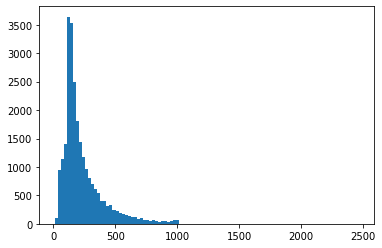

In [ ]:
#Let's do a histogram of number of words within the entire train sample
lengths = []
for x,_ in dataset_train_original:
  x = x.numpy().decode("utf-8").split()
  lengths += [len(x)]
plt.hist(lengths,bins=100)
plt.show()
plt.close()

In [10]:
#Let's try a simple text encoding: bag of words
vocabulary_size = 10_000
encoder = layers.TextVectorization(
    max_tokens = vocabulary_size, #this is the number of columns 
    standardize = "lower_and_strip_punctuation", #make everything lower case and
    output_mode = "multi_hot" #this makes it a bag of words
)
encoder.adapt(dataset_train_original.map(lambda text,label: text).batch(2048)) #data includes x (text), y(label); mapping just romves the y and leaves x(text). Batching allows parallelization

In [11]:
encoder.get_vocabulary()[:10]
# ['[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i']
# here '[UNK]' stands for the unknown words, i.e., those among that did not make it to the most occuring $vocabulary_size words.
# '[UNK]' is not counted, the rest of the words are sorted according to their occurrence counts

['[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i']

In [12]:
# An example of how this encoder (trained with IMDB reviews) would encode some random text 
text = 'Hello my dear friends! It is so great to be here today!'
text_encoded = encoder(text)
print(text_encoded)
#This doesn't help: we see all 

tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(10000,), dtype=float32)


In [13]:
def multi_hot_to_string(multi_hot):
    s = "".join([str(int(x)) for x in multi_hot])
    return s
text_encoded = encoder(text).numpy()
print(multi_hot_to_string(text_encoded))

0000011010000000000000000001000000000100000000000000000100000000000000000000000000001000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [14]:
#do the opposite: get the tokens from text_encoded
for i,num in enumerate(text_encoded):
  if num == 1:
    print(encoder.get_vocabulary()[i])

to
is
it
be
so
my
great
here
friends
today
dear
hello


In [21]:
dataset_train = dataset_train_original.cache() #we want to have preprocessed data in quick access memory (they will be accesed multiple times , for each epoch)
dataset_train = dataset_train.shuffle(25_000) #we don't want the model to learn the order (or overfit to the sequence)
dataset_train = dataset_train.batch(128)

dataset_validate = dataset_validate_original.cache()
#no shuffling is needed here
dataset_validate = dataset_validate.batch(128) #batching allows parallel computation, and speed up  

dataset_test = dataset_test_original.batch(128) #again to speed up

In [16]:
model  = models.Sequential()
model.add(encoder)
model.add(layers.Dense(64,activation="relu"))
model.add(layers.Dense(1,activation="sigmoid")) # output should be zero or one
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 10000)            0         
 ectorization)                                                   
                                                                 
 dense_2 (Dense)             (None, 64)                640064    
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 640,129
Trainable params: 640,129
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

history = model.fit(
    dataset_train,
    epochs = 10,
    validation_data=dataset_validate
)

Epoch 1/10
196/196 [==============================] - 9s 39ms/step - loss: 0.3362 - accuracy: 0.8636 - val_loss: 0.2980 - val_accuracy: 0.8794
Epoch 2/10
196/196 [==============================] - 7s 34ms/step - loss: 0.1891 - accuracy: 0.9297 - val_loss: 0.3098 - val_accuracy: 0.8755
Epoch 3/10
196/196 [==============================] - 7s 34ms/step - loss: 0.1453 - accuracy: 0.9466 - val_loss: 0.3510 - val_accuracy: 0.8701
Epoch 4/10
196/196 [==============================] - 6s 33ms/step - loss: 0.1132 - accuracy: 0.9596 - val_loss: 0.4049 - val_accuracy: 0.8641
Epoch 5/10
196/196 [==============================] - 7s 33ms/step - loss: 0.0899 - accuracy: 0.9680 - val_loss: 0.4544 - val_accuracy: 0.8606
Epoch 6/10
196/196 [==============================] - 7s 33ms/step - loss: 0.0725 - accuracy: 0.9747 - val_loss: 0.5180 - val_accuracy: 0.8538
Epoch 7/10
196/196 [==============================] - 7s 33ms/step - loss: 0.0563 - accuracy: 0.9814 - val_loss: 0.5727 - val_accuracy: 0.8547

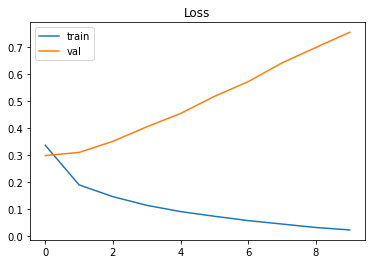

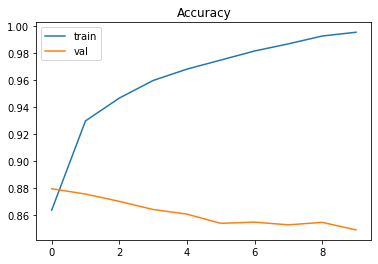

In [26]:
def render_history(history):
  plt.plot(history.history["loss"],label="train")
  plt.plot(history.history["val_loss"],label="val")
  plt.title("Loss")
  plt.legend()
  plt.show()
  plt.close()

  plt.plot(history.history["accuracy"],label="train")
  plt.plot(history.history["val_accuracy"],label="val")
  plt.title("Accuracy")
  plt.legend()
  plt.show()
  plt.close()
  pass

render_history(history)
